In [ ]:
import os
import zipfile
import requests

def download_and_extract(url, extract_to):
    zip_path = os.path.join(extract_to, "dataset.zip")
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Download the dataset if not already downloaded
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Dataset downloaded to {zip_path}")

    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed.")
    return extract_to  # Return the extraction directory path

def main():
    # Define dataset URL and extraction path
    dataset_url = "https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip"
    extract_to = "./datasets"

    # Download and extract the dataset
    data_path = download_and_extract(dataset_url, extract_to)

    # Check available directories
    print("Available directories:", os.listdir(data_path))

    # Locate the PetImages folder directly
    pet_images_dir = os.path.join(data_path, "PetImages")
    if not os.path.exists(pet_images_dir):
        raise FileNotFoundError(f"'PetImages' folder not found in {data_path}.")

    print("PetImages folder located at:", pet_images_dir)

    # Add your logic for data preparation and model training here
    # For example:
    # train_generator, validation_generator = prepare_data(pet_images_dir)
    print("Data preparation and training logic goes here.")
    print("Contents of './datasets':", os.listdir("./datasets"))
    print("Contents of './datasets/PetImages':", os.listdir("./datasets/PetImages"))


if __name__ == "__main__":
    main()


Dataset downloaded to ./datasets/dataset.zip
Extracting dataset...
Extraction completed.
Available directories: ['readme[1].txt', 'MSR-LA - 3467.docx', 'dataset.zip', 'PetImages']
PetImages folder located at: ./datasets/PetImages
Data preparation and training logic goes here.
Contents of './datasets': ['readme[1].txt', 'MSR-LA - 3467.docx', 'dataset.zip', 'PetImages']
Contents of './datasets/PetImages': ['Cat', 'Dog']


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to clean the dataset
def clean_dataset(directory):
    """Remove non-image or corrupted files from the dataset."""
    for category in ["Dog", "Cat"]:
        folder = os.path.join(directory, category)
        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue

        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Removing corrupted or non-image file: {file_path}")
                os.remove(file_path)

# Function to prepare data
def prepare_data(data_path):
    datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
    train_generator = datagen.flow_from_directory(
        data_path, target_size=(64, 64), batch_size=32, class_mode="binary", subset="training"
    )
    validation_generator = datagen.flow_from_directory(
        data_path, target_size=(64, 64), batch_size=32, class_mode="binary", subset="validation"
    )
    return train_generator, validation_generator


In [ ]:
# Function to build CNN model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [ ]:
# Function to split the given photo into sub-images
def split_image(image_path, grid_size=(4, 4)):
    """Splits the uploaded image into sub-images based on grid size."""
    image = Image.open(image_path)
    image = image.convert("RGB")
    img_width, img_height = image.size
    grid_w, grid_h = grid_size
    sub_width, sub_height = img_width // grid_w, img_height // grid_h

    sub_images = []
    for i in range(grid_h):
        for j in range(grid_w):
            box = (j * sub_width, i * sub_height, (j + 1) * sub_width, (i + 1) * sub_height)
            sub_image = image.crop(box)
            sub_images.append(sub_image)
    return sub_images

In [ ]:
# Function to preprocess sub-images
def preprocess_images(sub_images):
    """Resize and normalize images for the model."""
    processed_images = []
    for img in sub_images:
        img = img.resize((64, 64))  # Resize to match model input size
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        processed_images.append(img_array)
    return np.array(processed_images)

# Function to predict and count dogs
def predict_and_count_dogs(model, processed_images):
    """Predict each sub-image and count how many are classified as dogs."""
    predictions = model.predict(processed_images)
    dog_count = np.sum(predictions > 0.5)  # Count predictions > 0.5 as "dog"
    return predictions, int(dog_count)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.4865 - loss: 0.7379 - val_accuracy: 0.4875 - val_loss: 0.6914
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.5140 - loss: 0.6914 - val_accuracy: 0.4719 - val_loss: 0.7174
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - accuracy: 0.5663 - loss: 0.6856 - val_accuracy: 0.5250 - val_loss: 0.6841
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.5632 - loss: 0.6765 - val_accuracy: 0.5906 - val_loss: 0.6642
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.6086 - loss: 0.6530 - val_accuracy: 0.6187 - val_loss: 0.6557


Model saved as cat_dog_classifier.h5
Loading model...


Splitting the image into sub-images...
Preprocessing sub-images...
Predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Number of dogs detected: 6


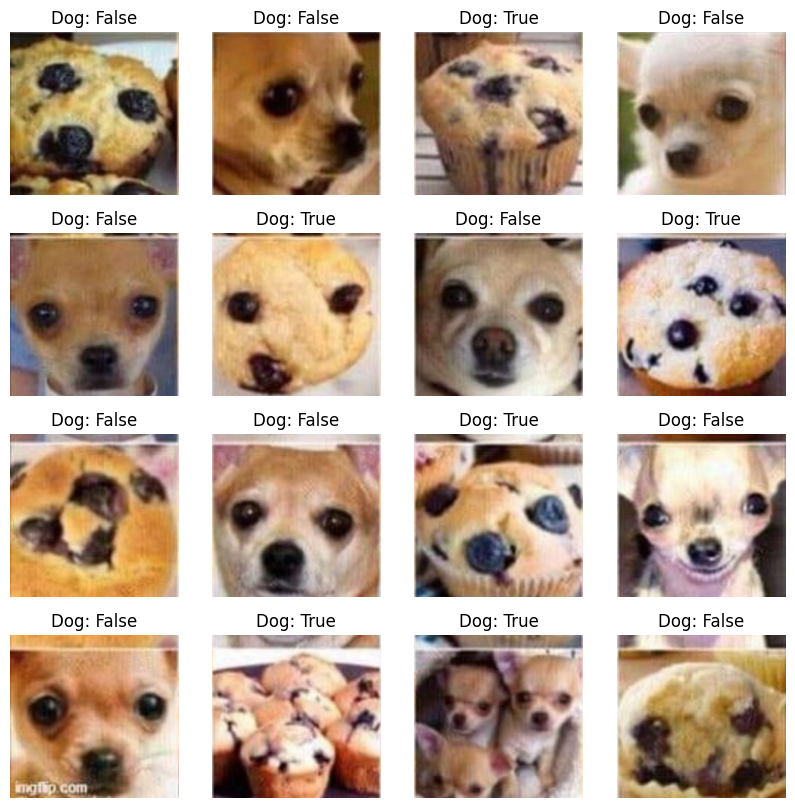

In [ ]:
# Main function
def main():
    # Train and save the model
    pet_images_dir = "./datasets/PetImages"
    clean_dataset(pet_images_dir)
    train_generator, validation_generator = prepare_data(pet_images_dir)

    model = build_model()
    history = model.fit(
        train_generator,
        steps_per_epoch=50,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=10
    )
    model.save("cat_dog_classifier.h5")
    print("Model saved as cat_dog_classifier.h5")

    # Predict on a given photo
    uploaded_image_path = "/content/cats and dogs .jpg"  # Path to the uploaded photo
    print("Loading model...")
    model = load_model("cat_dog_classifier.h5")

    # Split the photo into sub-images
    print("Splitting the image into sub-images...")
    sub_images = split_image(uploaded_image_path, grid_size=(4, 4))  # Assuming a 4x4 grid

    # Preprocess sub-images
    print("Preprocessing sub-images...")
    processed_images = preprocess_images(sub_images)

    # Predict and count dogs
    print("Predicting...")
    predictions, dog_count = predict_and_count_dogs(model, processed_images)

    # Display results
    print(f"Number of dogs detected: {dog_count}")
    plt.figure(figsize=(10, 10))
    for i, (img, pred) in enumerate(zip(sub_images, predictions)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Dog: {pred[0] > 0.5}")
        plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()
